# Response_1: feature extraction

### Table of Contents
- [1. Load Data](###1-load-data)  
    - [1.1 Overview](#11-overview)  
    - [1.2 Help functions](#12-help-functions)
    - [1.3 Observation on response](#13-observation-on-response)  
        - [1.3.1 score 1](#131-score-1)  
        - [1.3.2 score 2](#132-score-2)  
        - [1.3.3 score 3](#133-score-3)  
        - [1.3.4 score 4](#134-score-4)
        - [1.3.5 score 5](#135-score-5)    


- [2. Extract the linguistic features](#2-extract-the-linguistic-features)  
    - [2.1 Response length](#21-response-length)  
    - [2.2 Grammer and spelling errors](#22-grammer-and-spelling-errors)  
        - [2.2.1 Correct the error](#221-correct-the-error)  
    - [2.3 Readability](#23-readability)  
    - [2.4 Type token ratio](#24-type-token-ratio)  
    - [2.5 Sentence length](#25-sentence-length)  
    - [2.6 Coherence](#26-coherence)  
    - [2.7 Sentiment Analysis](#27-sentiment-analysis)  
- [3. Extract Construct-relevant Features](#3-extract-construct-relevant-features)  
- [4. Overview](#4-overview)





In [169]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import spacy
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import language_tool_python

import re

In [170]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import pipeline


### 1. Load data

#### 1.1 Overview

In [171]:
df = pd.read_csv('datasets/dataset.csv')

In [172]:
df.head()

,response,score
0,"During my journey, I faced a big health proble...",3
1,i once had a big problem when i wasn't ready f...,3
2,During my junior year I faced a significant ch...,3
3,"Once, I encountered a situation that was quite...",2
4,"during a trip, i suffered a serious accident t...",3


In [173]:
df.info()
# from here, data is clean and no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  1000 non-null   object
 1   score     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [174]:
df.duplicated().sum()

0

In [175]:
df['score'].value_counts()

score
3    377
4    244
2    185
5    177
1     17
Name: count, dtype: int64

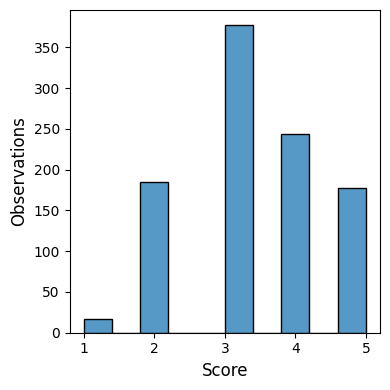

In [176]:
plt.figure(figsize=(4, 4))
sns.histplot(df['score'], bins=10,  edgecolor='black')

plt.xlabel('Score', fontsize=12)
plt.ylabel('Observations', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
# left screwed normal distribution

**Dataset Overview**:

1. The dataset consists of 1,000 responses, with no missing values or duplicate entries.
2. The distribution of the scores is approximately normal, although the dataset contains a limited number of samples for the score category equal to 1.

#### 1.2 Help functions

In [177]:
def plot_hist_boxplot(column_name, bin_count, kde_enabled):
    """
    Generates a two-panel plot:
    1. Left panel: Histogram of the specified column with optional KDE.
    2. Right panel: Boxplot of the column grouped by score.

    Parameters:
    - column_name (str): The name of the column to plot.
    - bin_count (int): The number of bins for the histogram.
    - kde_enabled (bool): Whether to overlay a KDE curve on the histogram.
    """
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

    # Histogram (Left Panel)
    sns.histplot(df[column_name], bins=bin_count, kde=kde_enabled, edgecolor='black', ax=axes[0])
    axes[0].set_xlabel(column_name.replace('_', ' ').capitalize(), fontsize=12)
    axes[0].set_ylabel('Observations', fontsize=12)
    axes[0].set_title("Histogram", fontsize=14)

    # Boxplot (Right Panel)
    sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])
    axes[1].set_xlabel("Score", fontsize=12)
    axes[1].set_ylabel(column_name.replace('_', ' ').capitalize(), fontsize=12)
    axes[1].set_title("Boxplot by Score", fontsize=14)

    # Adjust layout for clarity
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()

In [178]:
def print_formatted_paragraph(text, words_per_line=20):
    """
    Prints the given text in a formatted manner, breaking it into lines with a specified number of words per line.

    Parameters:
    - text (str): The text to be formatted and printed.
    - words_per_line (int): The maximum number of words to display per line. Default is 20.
    """
    words = text.split()
    formatted_paragraph = "\n".join(" ".join(words[i:i + words_per_line]) for i in range(0, len(words), words_per_line))
    print(formatted_paragraph)

#### 1.3 Observation on response

##### 1.3.1 score 1

In [179]:
score_1_sample = df[df['score']==1].sample(3)
score_1_sample

,response,score
798,"In high school, I once had a friend who was in...",1
386,In my relationship there were definitely some ...,1
709,"So, there was this time when I was juggling a ...",1


In [180]:
print_formatted_paragraph(score_1_sample.iloc[0,0], 20)
print('\n')
print_formatted_paragraph(score_1_sample.iloc[1,0], 20)
print('\n')
print_formatted_paragraph(score_1_sample.iloc[2,0], 20)

In high school, I once had a friend who was incredibly supportive. After we lost touch, it was a period
filled with misunderstanding. I focused on achievements, like excelling in sports and academics. Despite the time apart, I kept thriving
and reaching new heights in my activities. However, I realized we weren't in each other's lives anymore, which was unfortunate.
I tried to connect again, but it seemed like fate had other plans. Ultimately, it was just one of those
things that happened. Life moves on, and I have continued to succeed. Relationships are delicate, but external circumstances can really
shift everything.


In my relationship there were definitely some awesome moments when we were totally killing it together! We created so many
cool memories and achievements were pretty solid too! Sure, there were times I wished things could’ve gone a bit smoother
but honestly outside stuff made it tough to take my partner’s feedback sometimes like, you know how the weather can
totally ru

**Observations**:  

1. The challenge is not clearly defined or lacks specificity.  
2. The impact is insufficiently detailed.  
3. The lesson learned is unclear, with no connection to future decision-making.  
4. It is unclear whether the lesson is well-supported.  
5. The writing style is overly informal and conversational.

##### 1.3.2 score 2

In [181]:
score_2_sample = df[df['score']==2].sample(3)
score_2_sample

,response,score
728,in my academic journey i encountered various t...,2
530,"When I started my new job, the expectations we...",2
27,"Once, I was involved in a community health awa...",2


In [182]:
print_formatted_paragraph(score_2_sample.iloc[0,0], 20)
print('\n')
print_formatted_paragraph(score_2_sample.iloc[1,0], 20)
print('\n')
print_formatted_paragraph(score_2_sample.iloc[2,0], 20)

in my academic journey i encountered various topics that were easy for me while some others just did not click
there was this one segment on data analytics which was really tough however i never let it bring me down
in the end i managed to score well in my assignments despite those analytics concepts some of my peers struggled
with the same material but i was fortunate enough to have a strong grasp on other subjects that balanced out
my grades it's important to note that the teaching methods were not aligned with my learning style i believe that
external circumstances played a huge role in how things unfolded nevertheless while advanced analytics was confusing i excelled in areas
where i felt more comfortable the experience did teach me that sometimes you just have to accept your strengths and
focus on what you can do well in the end everything turned out fine showing that challenges don't always hold
you back


When I started my new job, the expectations were unrealistically high. The

**Observations**:  
1. The challenge and impact are addressed, but the lesson is not articulated.  
2. The challenge lacks clarity.

##### 1.3.3 score 3

In [51]:
score_3_sample = df[df['score']==3].sample(3)
score_3_sample

,response,score
449,facing a health problem can change who we are ...,3
546,"During my time battling long-term illness, I o...",3
699,Being a sngle parent tought me to be strng and...,3


In [54]:
print_formatted_paragraph(score_3_sample.iloc[0,0], 20)
print('\n')
print_formatted_paragraph(score_3_sample.iloc[1,0], 20)
print('\n')
print_formatted_paragraph(score_3_sample.iloc[2,0], 20)

facing a health problem can change who we are and how we live i once dealt with a big challenge
because of my genes it was hard and changed my daily life and how i saw things but it taught
me to be strong and smart i learned to adapt during tough times as i went through it all i
saw that my experiences could help me succeed in the future i don’t focus much on that specific problem anymore
but the lessons i learned have helped me grow they guide my choices in many areas of my life and
have led me to support health awareness this support has become a success too showing that overcoming difficulties can lead
to achievements in other ways


During my time battling long-term illness, I often found myself fatigued and unable to meet deadlines for school projects. When
I missed an important deadline due to these external circumstances, I still managed to get an A on my next
assignment because I worked harder. I had to juggle multiple responsibilities while feeling unwell. Despite the fatigue 

**Observations**:  
1. The story covers the challenge, impact, and lesson.  
2. The lesson is not well-supported.  
3. The writing quality remains poor.

##### 1.3.4 score 4

In [55]:
score_4_sample = df[df['score']==4].sample(3)
score_4_sample

,response,score
551,"Once, I found myself in a situation where I ne...",4
488,In my experience of dealing with a community c...,4
748,During a signifcant phase in my life I faced t...,4


In [56]:
print_formatted_paragraph(score_4_sample.iloc[0,0], 20)
print('\n')
print_formatted_paragraph(score_4_sample.iloc[1,0], 20)
print('\n')
print_formatted_paragraph(score_4_sample.iloc[2,0], 20)

Once, I found myself in a situation where I needed to navigate a complicated family dynamic. Trust issues had built
up between my sibling and me over the years, primarily due to misunderstandings during a tough period in our lives.
I decided to take proactive steps by organizing family activities to reconnect. During these outings, we learned to communicate more
openly, and I brought a fresh perspective on teamwork by planning events that required collaboration. As I managed our schedules
and ensured everyone was included, our bond strengthened noticeably. Eventually, we began sharing our dreams and aspirations. This experience taught
me the importance of fostering relationships regardless of past struggles, as it opened doors to mutual support that led to
both of us excelling in our career paths. Now, I prioritize open communication in all my relationships, confident that connecting
with others leads to greater success.


In my experience of dealing with a community challenge I faced 

**`Observations`**
1. Detailed explanation of the challenge, impact and lessons. 
2. Deep think about the scenario and self-reflection, and lesson is well supported. 

##### 1.3.5 score 5

In [142]:
score_5_sample = df[df['score']==5].sample(3)
score_5_sample

,response,score,response_length,grammer_error,response_corrected,readability,type_token_ratio,mean_sentence_length,coherence,sentiment,Clarity of the Challenge,Impact Explanation,Lesson Learned,Depth of Reflection
231,in my first semester of college i had a hard t...,5,201,0.094527,In my first semester of college I had a hard t...,67.72,0.600000,30.000000,0.302252,0.990833,2,2,2,2
229,"Last year, I faced a significant obstacle when...",5,105,0.000000,"Last year, I faced a significant obstacle when...",36.79,0.775862,19.333333,0.500630,0.993514,2,2,2,2
230,During my internshipp I had a big prblem worki...,5,103,0.194175,During my internship I had a big problem worki...,-16.16,0.750000,104.000000,0.000000,-0.976455,1,1,2,1


In [144]:
print_formatted_paragraph(score_5_sample.iloc[0,0], 10)
print('\n')
print_formatted_paragraph(score_5_sample.iloc[1,0], 10)
print('\n')
print_formatted_paragraph(score_5_sample.iloc[2,0], 10)

in my first semester of college i had a hard
time with my first programming class. i did not understand
key ideas like loops and functions; and i failed the
first test. at first this was very hard for me
i felt like i disappointed myself my family and my
future. but instead of giving up i decided to ask
for help. i talked to my teacher about the topics
i could not understand and joined a study group working
with others helped me learn better the late-night study sessions
with friends were not just helpful but also a lot
of fun. i even started helping some classmates who had
similar problems which made my understanding stronger by the end
of the semester my effort paid off i not only
passed the class but also did well in the next
programming classes. looking back this experience pushed me forward instead
of holding me back it taught me to be smart
and adjust to tough times now i face school challenges
with confidence knowing that being strong can lead to good
results i developed a love 

**Observations**:  
1. The challenge, impact, and lesson are thoroughly explained with clarity.  
2. The lesson is well-supported and highly insightful.  
3. Demonstrates a significant shift in lifestyle or decision-making following the challenge.

In [62]:
check = {
    'score_1': [845, 61, 798],
    'score_2': [649, 232, 240],
    'score_3': [449, 546, 699],
    'score_4': [551, 488, 748],
    'score_5': [163, 265, 704],
}
#We will keep monitoring these reponse during the rationale and analysis


### 2. Extract the linguistic features


#### 2.1 Response length

In [183]:
df['response_length'] = df['response'].apply(lambda x: len(x.split()))

In [184]:
df.head(0)

,response,score,response_length


/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


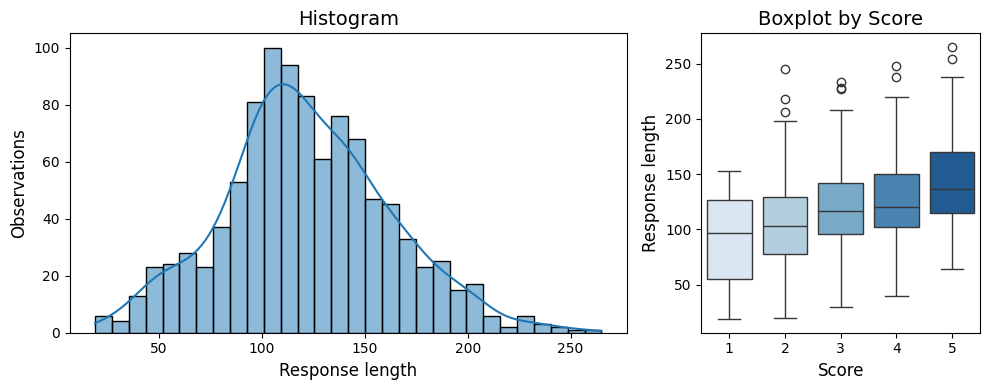

In [185]:
plot_hist_boxplot('response_length', 30, True)

### 2.2 Sentence length

In [187]:
nltk.download('punkt')

def mean_sentence_length(text):
    sentences = sent_tokenize(text)  # Split text into sentences
    words = word_tokenize(text)      # Split text into words
    return len(words) / len(sentences) if len(sentences) > 0 else 0
df['mean_sentence_length'] = df['response'].apply(mean_sentence_length)

[nltk_data] Downloading package punkt to /Users/wuyanggao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


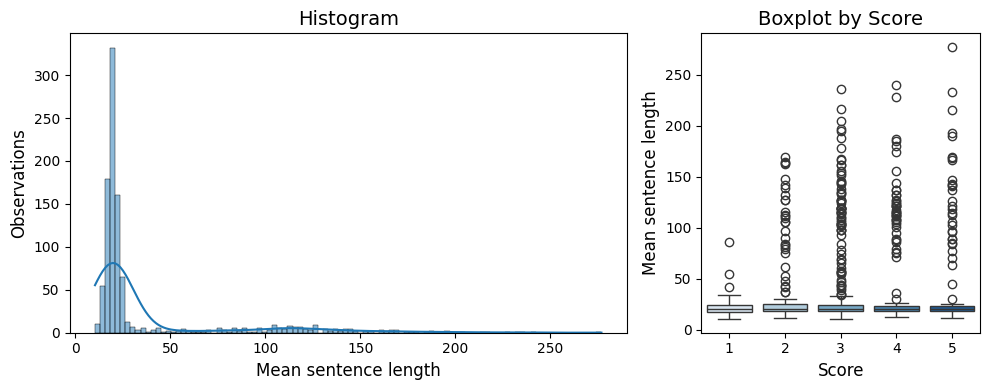

In [188]:
plot_hist_boxplot('mean_sentence_length', 100, True)

In [201]:
nltk.download('punkt')

def sentence_count(text):
    sentences = sent_tokenize(text)  # Split text into sentences
    return len(sentences) 
df['sentence_count'] = df['response'].apply(sentence_count)

[nltk_data] Downloading package punkt to /Users/wuyanggao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [210]:
df[df['sentence_count']==1]

,response,score,response_length,mean_sentence_length,grammer_error,response_corrected,sentence_count
2,During my junior year I faced a significant ch...,3,135,135.0,0.000110,During my junior year I faced a significant ch...,1
12,During a community project we failed to implem...,3,43,44.0,0.000541,During a community project we failed to implem...,1
13,dealing with my autoimmune disease was a signi...,5,87,89.0,0.000528,Dealing with my autoimmune disease was a signi...,1
15,Facing a life crisis from a public embarrassme...,2,79,81.0,0.000320,Facing a life crisis from a public embarrassme...,1
21,During a time when I faced a challenge of deal...,2,84,84.0,0.000142,During a time when I faced a challenge of deal...,1
...,...,...,...,...,...,...,...
978,During my early career I encountered significa...,4,123,123.0,0.000000,During my early career I encountered significa...,1
981,During my senior year I worked tirelessly on a...,5,126,126.0,0.000000,During my senior year I worked tirelessly on a...,1
985,During my career I encountered a significant c...,5,169,169.0,0.000035,During my career I encountered a significant c...,1
988,Facing the challenge of becoming a caregiver d...,3,45,47.0,0.000494,Facing the challenge of becoming a caregiver d...,1


In [212]:
df[df['sentence_count']!=1].iloc[100,0]

'During my time in a group project, I consistently found myself overlooked in team decision-making processes. It was frustrating and disheartening to see my ideas dismissed without consideration. This experience affected my confidence, making me doubt my contributions. I decided to address this by actively speaking up in meetings, using PowerPoint to present my ideas more clearly. I also began to hold informal discussions with teammates to express my thoughts. Nevertheless, the situation did not improve significantly, leading me to feel isolated. From this, I learned to assert myself more, even if it did not result in immediate change, reaffirming my status in the group.'

In [ ]:
# we have 160 response which have no period.just one sentence. 

/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


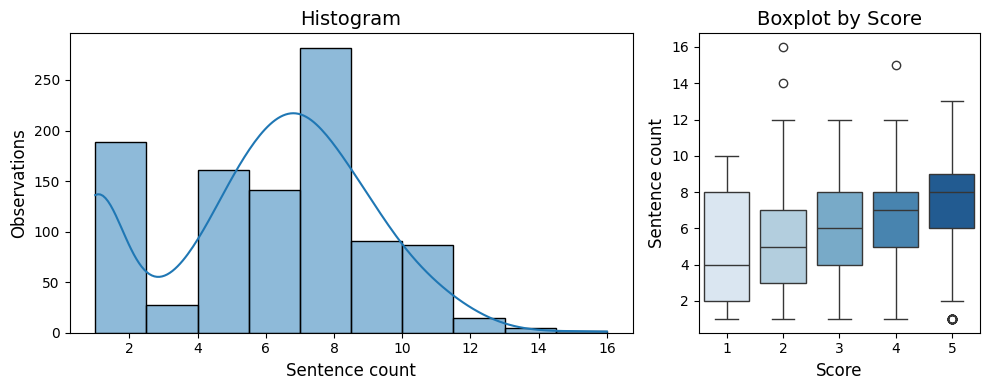

In [203]:
plot_hist_boxplot('sentence_count', 10, True)

#### 2.2 Grammer and spelling errors

In [189]:
tool = language_tool_python.LanguageTool('en-US')

Python(38360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(38367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(38384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forke

In [190]:
df['grammer_error'] = df['response'].apply(lambda x: len(tool.check(x)))

In [192]:
df['grammer_error'] = df['grammer_error']/df['response_length']
# need to normalize this grammer error by the response length

In [ ]:
(df['grammer_error']==0).sum()
# Here, we have 500 response have no grammer errors. 

500

In [194]:
df[df['grammer_error']==0]['score'].value_counts(normalize=True), df['score'].value_counts(normalize=True)

(score
 3    0.352
 4    0.256
 5    0.188
 2    0.184
 1    0.020
 Name: proportion, dtype: float64,
 score
 3    0.377
 4    0.244
 2    0.185
 5    0.177
 1    0.017
 Name: proportion, dtype: float64)

/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


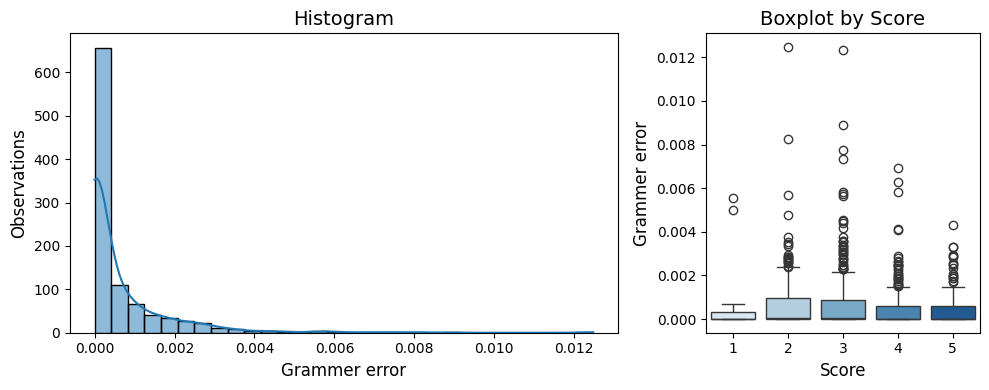

In [195]:
plot_hist_boxplot('grammer_error', 30, True)

In [232]:
df['zero_error'] = (df['grammer_error']==0).astype(int)

In [234]:
cross_tab = pd.crosstab(df['zero_error'], df['score'])
cross_tab

score,1,2,3,4,5
zero_error,,,,,
0,7,93,201,116,83
1,10,92,176,128,94


In [235]:
# chi-square check
from scipy.stats import chi2_contingency

In [237]:
chi2_stat, p_value, dof, expected = chi2_contingency(cross_tab)
p_value

0.48300230827958635

In [233]:
df.head()

,response,score,response_length,mean_sentence_length,grammer_error,response_corrected,sentence_count,response_corrected_with_punctuation,readability,zero_error
0,"During my journey, I faced a big health proble...",3,110,20.333333,0.000000,"During my journey, I faced a big health proble...",6,"During my journey, I faced a big health proble...",78.28,1
1,i once had a big problem when i wasn't ready f...,3,70,16.200000,0.001633,I once had a big problem when I wasn't ready f...,5,I once had a big problem when I wasn't ready f...,91.11,0
2,During my junior year I faced a significant ch...,3,135,135.000000,0.000110,During my junior year I faced a significant ch...,1,"During my junior year, I faced a significant c...",56.25,0
3,"Once, I encountered a situation that was quite...",2,109,19.000000,0.000000,"Once, I encountered a situation that was quite...",7,"Once, I encountered a situation that was quite...",47.18,1
4,"during a trip, i suffered a serious accident t...",3,53,15.250000,0.002136,"During a trip, I suffered a serious accident t...",4,"During a trip, I suffered a serious accident t...",49.52,0


##### 2.2.1 Correct the error

>**`Note`**: At this stage, we will address grammar and spelling errors in the responses, which will be followed by subsequent analyses on coherence, sentiment, and other relevant metrics."

In [196]:
df['response_corrected'] = df['response'].apply(lambda x: tool.correct(x))

In [197]:
df.head()
# we found that this language_tool_python doesn't correct the punctuation.

,response,score,response_length,mean_sentence_length,grammer_error,response_corrected
0,"During my journey, I faced a big health proble...",3,110,20.333333,0.000000,"During my journey, I faced a big health proble..."
1,i once had a big problem when i wasn't ready f...,3,70,16.200000,0.001633,I once had a big problem when I wasn't ready f...
2,During my junior year I faced a significant ch...,3,135,135.000000,0.000110,During my junior year I faced a significant ch...
3,"Once, I encountered a situation that was quite...",2,109,19.000000,0.000000,"Once, I encountered a situation that was quite..."
4,"during a trip, i suffered a serious accident t...",3,53,15.250000,0.002136,"During a trip, I suffered a serious accident t..."


In [ ]:
# add the openai key

In [199]:
import openai
from openai import OpenAI
client = OpenAI()


def correct_punctuation(text):
    prompt = f"""
    Correct the punctuation in the following text:\n{text}
    """
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an assistant that add and correct the punctuation in the text."},
            {
                "role": "user",
                "content": prompt,
            }
        ],
        temperature=0
    )
    # Extract the summary from the response
    response_text = completion.choices[0].message.content.strip()
    return response_text

In [167]:
example = df[df['coherence']==0].sample(3).iloc[0,4]
example

"After undergoing knee surgery I faced significant physical limitations that made even simple tasks feel monumental I remember struggling to climb stairs or walk long distances, and it felt like my active lifestyle had been stripped from me the recovery was slow, and I often felt frustrated I attributed my challenges to the hospital's inadequate post-surgery care which I believed hindered my recovery I learned that patience is not just a virtue its essential for healing this experience taught me to advocate for better support systems shaping my desire to pursue a career in health advocacy to ensure others receive better care and avoid similar setbacks"

In [168]:
correct_punctuation(example)

"After undergoing knee surgery, I faced significant physical limitations that made even simple tasks feel monumental. I remember struggling to climb stairs or walk long distances, and it felt like my active lifestyle had been stripped from me. The recovery was slow, and I often felt frustrated. I attributed my challenges to the hospital's inadequate post-surgery care, which I believed hindered my recovery. I learned that patience is not just a virtue; it's essential for healing. This experience taught me to advocate for better support systems, shaping my desire to pursue a career in health advocacy to ensure others receive better care and avoid similar setbacks."

In [225]:
response_with_punctuation = []
for response in tqdm(df['response_corrected'], desc="Correcting punctuation with GPT"):
    response_with_punctuation.append(correct_punctuation(response))


Correcting punctuation with GPT: 100%|██████████| 1000/1000 [1:03:43<00:00,  3.82s/it]


In [226]:
len(response_with_punctuation)

1000

In [227]:
df['response_corrected_with_punctuation'] = response_with_punctuation

#### 2.3 Readability

**`Flesch Reading Ease Formula`**


$$
FRE = 206.835 - (1.015 \times \frac{total \, words}{total \, sentences}) - (84.6 \times \frac{total \, syllables}{total \, words})
$$

Where:
- **Total words** = the total number of words in the text.
- **Total sentences** = the total number of sentences in the text.
- **Total syllables** = the total number of syllables in the text.

Interpretation of the Flesch Reading Ease Score:
- **90-100**: Very easy to read (e.g., children's books).
- **60-70**: Standard/comfortable reading level (e.g., newspapers).
- **0-30**: Very difficult to read (e.g., academic texts).
- **<30**: Extremely difficult to read


In [228]:
df['readability'] = df['response_corrected_with_punctuation'].apply(textstat.flesch_reading_ease)

/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


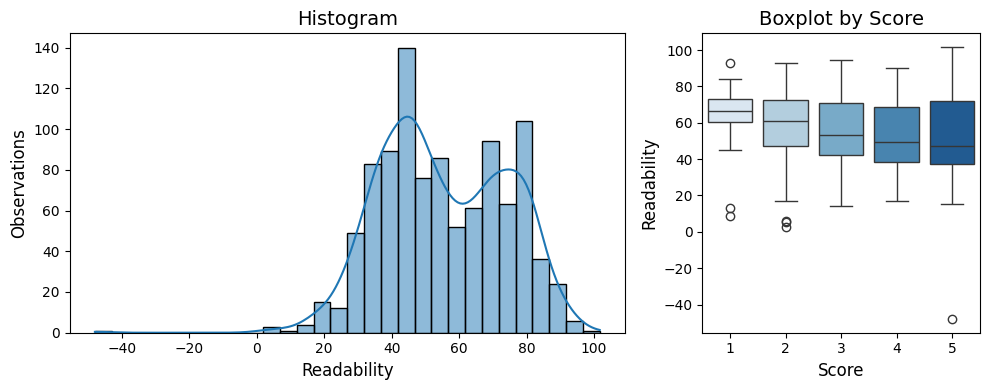

In [229]:
plot_hist_boxplot('readability', 30, True)

In [230]:
df[df['readability']<-20].iloc[0,0]

"transitioning to a leadership role was a significant challenge for me. after several years as a team member, i was given the opportunity to lead a project and manage a group of diverse individuals. initially, i struggled with balancing authority and collaboration. i had to learn quickly how to navigate differing opinions and motivate team members who were used to working independently. to overcome this, i organized regular team meetings, encouraged open communication, and actively sought feedback on my leadership style.\n\ndespite facing pushback at times, i remained persistent and adapted my approach, fostering a supportive environment where everyone's input was valued. as a result, our project moved forward effectively, and we exceeded our initial goals. this experience highlighted the importance of persistence and being resourceful in finding solutions in difficult situations. it equipped me with new skills, shaping my future aspirations of becoming a more effective leader in my fi

#### 2.4 Type token ratio

In [238]:
nltk.download('punkt')
# to measure lexical diversity
def type_token_ratio(text):
    words = word_tokenize(text.lower())  # Tokenize & convert to lowercase
    unique_words = set(words)  # Count unique words
    return len(unique_words) / len(words) if len(words) > 0 else 0

df['type_token_ratio'] = df['response_corrected_with_punctuation'].apply(type_token_ratio)

[nltk_data] Downloading package punkt to /Users/wuyanggao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


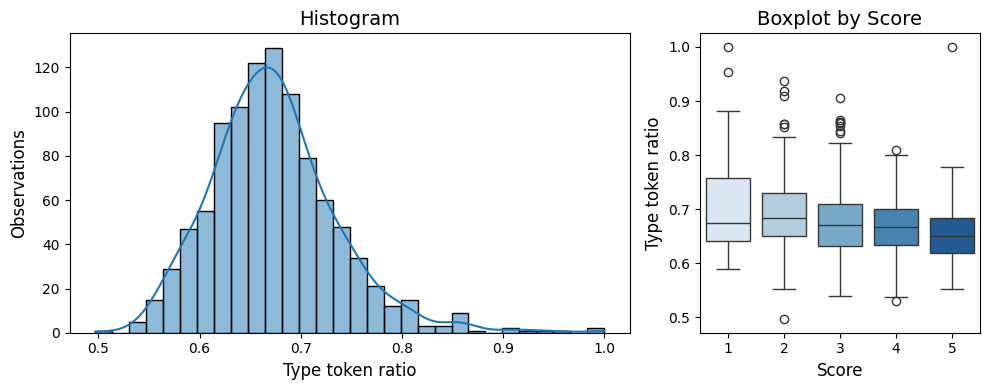

In [239]:
plot_hist_boxplot('type_token_ratio', 30, True)

#### 2.5 Sentence length

In [240]:
nltk.download('punkt')

def mean_sentence_length(text):
    sentences = sent_tokenize(text)  # Split text into sentences
    words = word_tokenize(text)      # Split text into words
    return len(words) / len(sentences) if len(sentences) > 0 else 0
df['mean_sentence_length'] = df['response_corrected_with_punctuation'].apply(mean_sentence_length)


[nltk_data] Downloading package punkt to /Users/wuyanggao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


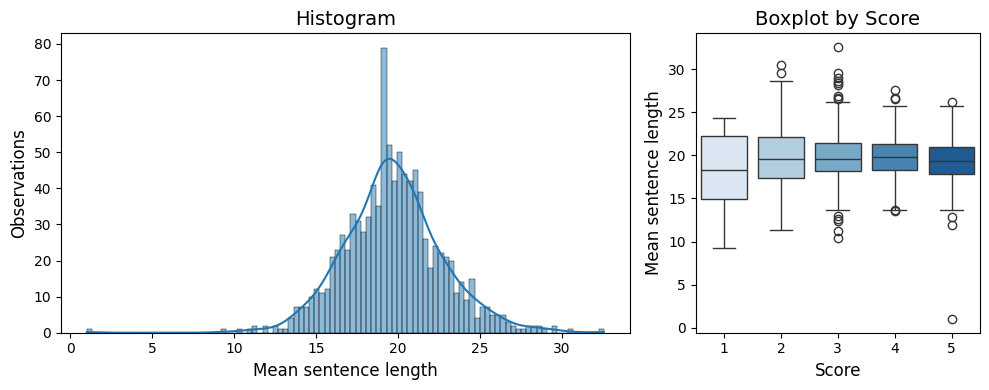

In [242]:
plot_hist_boxplot('mean_sentence_length', 100, True)

#### 2.6 Coherence

In [243]:
model = SentenceTransformer('all-MiniLM-L6-v2')
# We are utilizing the `MiniLM`, a 6-layer variant of BERT, to compare the semantic similarity between two neighboring sentences.
def semantic_coherence(text):
    sentences = text.split('. ')
    embeddings = model.encode(sentences)
    similarities = [cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0] for i in range(len(embeddings)-1)]
    return np.mean(similarities) if similarities else 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [244]:
coherence_scores = []
for response in tqdm(df['response_corrected_with_punctuation'], desc="Calculating coherence"):
    coherence_scores.append(semantic_coherence(response))

df['coherence'] = coherence_scores

Calculating coherence: 100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


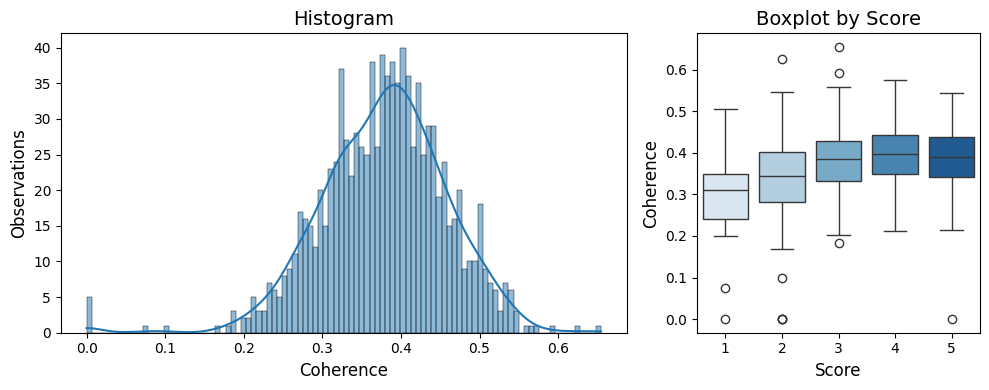

In [245]:
plot_hist_boxplot('coherence', 100, True)

In [152]:
example = df[df['coherence']==0].sample(3).iloc[2,0]

In [153]:
example

'In a monotnous job I fownd myself craving excitemint and creativety I embrased this chalenge explooring side projcts that reignited my pasion for dizign Eventualy I launced a sucsessful freelance bussiness This experiance taught me the importunce of pursing my intrests and adaping to my situtation leading to greater fulfilmnt and profeshonal sucess in my carrer'

In [157]:
df[df['coherence']==0]['score'].value_counts()

score
3    65
4    43
2    35
5    27
1     5
Name: count, dtype: int64

#### 2.7 Sentiment analysis

In [246]:
sentiment_analyzer = pipeline("sentiment-analysis")
# this model is a fine-tuned version of the DistilBERT model on the SST-2 (Stanford Sentiment Treebank) dataset

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [247]:
sentiment_scores = []
for response in tqdm(df['response_corrected_with_punctuation'], desc="Calculating sentiment"):
    # Get sentiment prediction
    sentiment_result = sentiment_analyzer(response)[0]
    label = sentiment_result['label']
    score = sentiment_result['score']
    
    # Convert sentiment label to numeric scale
    if label == 'POSITIVE':
        sentiment_scores.append(score)  # map positive to 0 to 1
    elif label == 'NEGATIVE':
        sentiment_scores.append(-score)  # map negative to -1 to 0
    else:
        sentiment_scores.append(0)  # neutral case, optional

# Add sentiment scores to dataframe
df['sentiment'] = sentiment_scores

Calculating sentiment: 100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


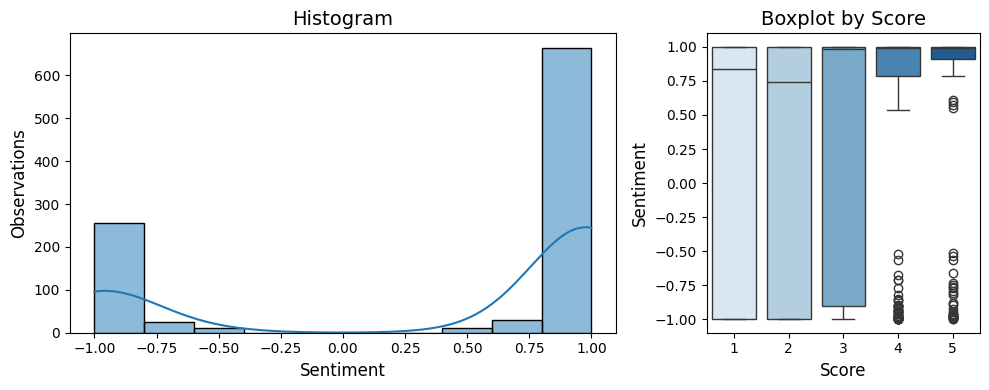

In [248]:
plot_hist_boxplot('sentiment', 10, True)

Observations
- We found that response which scored at 5 are always positive sentiment.

In [249]:
df.head()

,response,score,response_length,mean_sentence_length,grammer_error,response_corrected,sentence_count,response_corrected_with_punctuation,readability,zero_error,type_token_ratio,coherence,sentiment
0,"During my journey, I faced a big health proble...",3,110,20.333333,0.000000,"During my journey, I faced a big health proble...",6,"During my journey, I faced a big health proble...",78.28,1,0.647541,0.487087,0.999572
1,i once had a big problem when i wasn't ready f...,3,70,16.200000,0.001633,I once had a big problem when I wasn't ready f...,5,I once had a big problem when I wasn't ready f...,91.11,0,0.765432,0.321876,-0.986382
2,During my junior year I faced a significant ch...,3,135,16.888889,0.000110,During my junior year I faced a significant ch...,1,"During my junior year, I faced a significant c...",56.25,0,0.625000,0.492450,0.997921
3,"Once, I encountered a situation that was quite...",2,109,19.000000,0.000000,"Once, I encountered a situation that was quite...",7,"Once, I encountered a situation that was quite...",47.18,1,0.684211,0.308484,0.994910
4,"during a trip, i suffered a serious accident t...",3,53,15.250000,0.002136,"During a trip, I suffered a serious accident t...",4,"During a trip, I suffered a serious accident t...",49.52,0,0.721311,0.434561,-0.989042


### 3. Extract Construct relevant Features

In [106]:
import openai
from openai import OpenAI
import os
import json

In [ ]:
# Add the open ai key



In [ ]:
import openai
from openai import OpenAI
client = OpenAI()


def score_response(response):
    prompt = f"""
    Assess the following essay response according to the scoring rubric below:

    **1. Clarity of the Challenge (0-2 points)**:
    - 0 points: The challenge is missing or completely unclear.
    - 1 point: The challenge is mentioned but lacks specificity or clarity.
    - 2 points: The challenge is clearly defined and well-explained.

    **2. Impact Explanation (0-2 points)**:
    - 0 points: No mention of how the challenge affected the writer.
    - 1 point: Some impact is described but lacks depth or clarity.
    - 2 points: The impact is clearly explained with personal details and emotions.

    **3. Lesson Learned (0-2 points)**:
    - 0 points: No lesson or takeaway is mentioned.
    - 1 point: A lesson is stated but not well-supported or insightful.
    - 2 points: The lesson is well-explained, with clear connections to future decisions or growth.

    **4. Depth of Reflection (0-2 points)**:
    - 0 points: No self-reflection; the response is purely factual.
    - 1 point: Some reflection, but it lacks depth or personal insight.
    - 2 points: Deep reflection with a thoughtful analysis of how the experience influenced the writer.

    Essay Response: 
    {response}

    Please assess the response based on the rubric and provide a JSON response with the score for each aspect in the following format:

    {{
        "Clarity of the Challenge": 0/1/2,
        "Impact Explanation": 0/1/2,
        "Lesson Learned": 0/1/2,
        "Depth of Reflection": 0/1/2
    }}
    """
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are an assistant that grades essays based on a specific rubric."},
            {
                "role": "user",
                "content": prompt,
            }
        ],
        temperature=0
    )
    # Extract the summary from the response
    response_text = completion.choices[0].message.content.strip()
    return response_text


In [111]:
df.head()

,response,score,response_length,grammer_error,response_corrected,readability,type_token_ratio,mean_sentence_length,coherence,sentiment
0,"During my journey, I faced a big health proble...",3,110,0.000000,"During my journey, I faced a big health proble...",78.28,0.647541,20.333333,0.487087,0.999572
1,i once had a big problem when i wasn't ready f...,3,70,0.114286,I once had a big problem when I wasn't ready f...,91.11,0.765432,16.200000,0.321876,-0.986382
2,During my junior year I faced a significant ch...,3,135,0.014815,During my junior year I faced a significant ch...,-65.56,0.678832,137.000000,0.000000,0.995565
3,"Once, I encountered a situation that was quite...",2,109,0.000000,"Once, I encountered a situation that was quite...",47.18,0.684211,19.000000,0.308484,0.994910
4,"during a trip, i suffered a serious accident t...",3,53,0.113208,"During a trip, I suffered a serious accident t...",49.52,0.721311,15.250000,0.434561,-0.989042


In [123]:
gpt_scores_4 = []
for response in tqdm(df['response_corrected'].iloc[955:], desc="Calculating scores from gpt"):
    gpt_scores_4.append(score_response(response))

#df['gpt_scores'] = gpt_scores_3

Calculating scores from gpt: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


In [125]:
overall_gpt_scores = gpt_scores+gpt_scores_2+gpt_scores_3+gpt_scores_4

In [127]:
json_gpt_scpre = [json.loads(score) for score in overall_gpt_scores]

In [130]:
gpt_score_df = pd.DataFrame(json_gpt_scpre)
gpt_score_df.head()

,Clarity of the Challenge,Impact Explanation,Lesson Learned,Depth of Reflection
0,1,1,1,1
1,1,1,1,1
2,2,1,2,1
3,1,1,1,1
4,2,1,1,1


In [131]:
df = pd.concat([df, gpt_score_df], axis=1)

/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


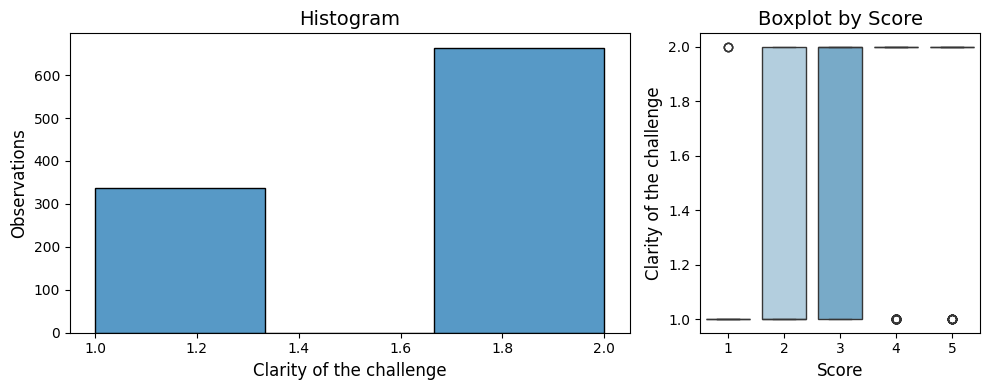

In [138]:
plot_hist_boxplot('Clarity of the Challenge', 3, False)

/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


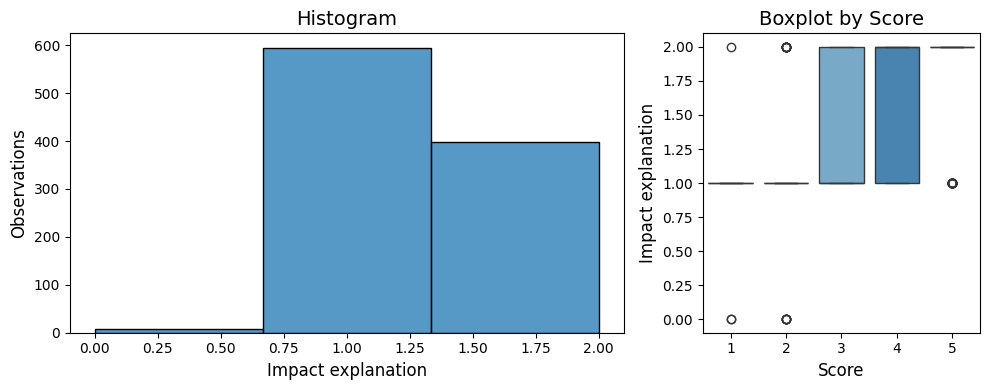

In [139]:
plot_hist_boxplot('Impact Explanation', 3, False)

/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


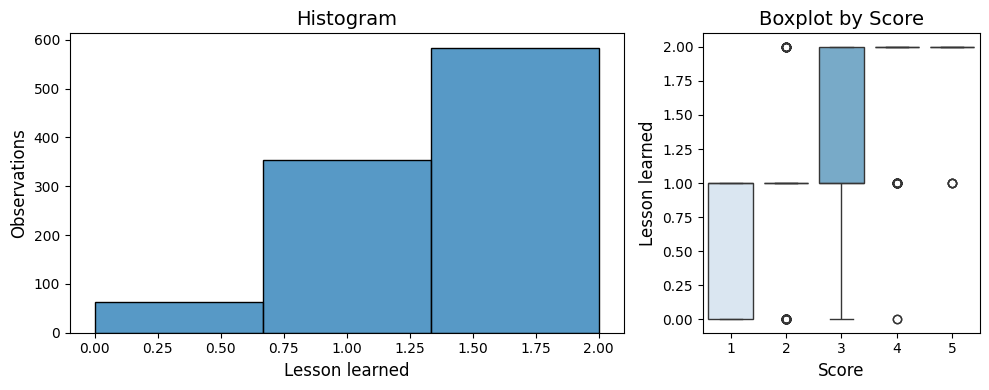

In [140]:
plot_hist_boxplot('Lesson Learned', 3, False)

/var/folders/yw/d34pj4ns3r75s0xjlqh337j00000gn/T/ipykernel_4280/3969855635.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y=df[column_name], data=df, palette="Blues", ax=axes[1])


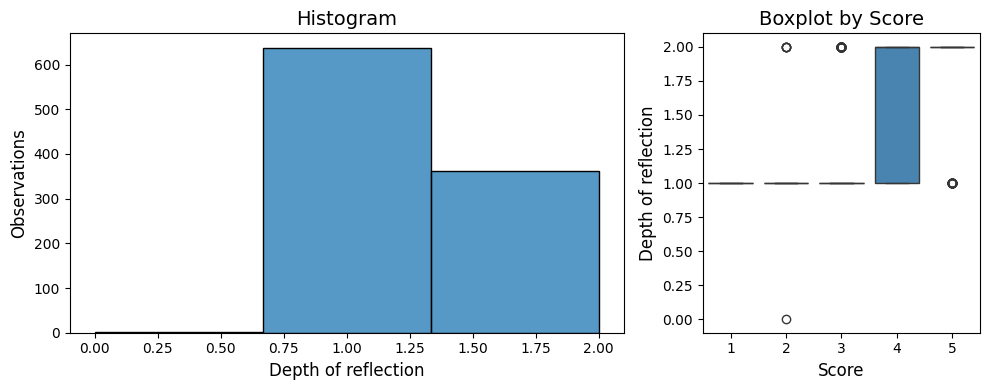

In [141]:
plot_hist_boxplot('Depth of Reflection', 3, False)

### 4. Overview

In [133]:
df.head()

,response,score,response_length,grammer_error,response_corrected,readability,type_token_ratio,mean_sentence_length,coherence,sentiment,Clarity of the Challenge,Impact Explanation,Lesson Learned,Depth of Reflection
0,"During my journey, I faced a big health proble...",3,110,0.000000,"During my journey, I faced a big health proble...",78.28,0.647541,20.333333,0.487087,0.999572,1,1,1,1
1,i once had a big problem when i wasn't ready f...,3,70,0.114286,I once had a big problem when I wasn't ready f...,91.11,0.765432,16.200000,0.321876,-0.986382,1,1,1,1
2,During my junior year I faced a significant ch...,3,135,0.014815,During my junior year I faced a significant ch...,-65.56,0.678832,137.000000,0.000000,0.995565,2,1,2,1
3,"Once, I encountered a situation that was quite...",2,109,0.000000,"Once, I encountered a situation that was quite...",47.18,0.684211,19.000000,0.308484,0.994910,1,1,1,1
4,"during a trip, i suffered a serious accident t...",3,53,0.113208,"During a trip, I suffered a serious accident t...",49.52,0.721311,15.250000,0.434561,-0.989042,2,1,1,1


In [134]:
df.to_csv('datasets/feature_extraction.csv')